# Notebook 1.1: Discrete-Time Linear Systems & Prediction

Welcome to the first core notebook on Model Predictive Control! In this session, we'll lay the groundwork for understanding how MPC predicts the future behavior of systems. We'll focus on discrete-time Linear Time-Invariant (LTI) systems, which are fundamental building blocks for many MPC applications.

**Goals of this Notebook:**
1. Define LTI state-space models using Python and NumPy.
2. Understand how to discretize continuous-time LTI systems.
3. Implement the step-by-step prediction equations for future states and outputs.
4. Construct the compact prediction matrices $\mathbf{F}$ and $\mathbf{\Phi}$.
5. Work through an interactive example: predicting the trajectory of a double integrator system.

## 1. Importing Necessary Libraries

We'll primarily use NumPy for numerical operations (especially matrix algebra) and Matplotlib for plotting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete # For discretizing continuous systems

# Optional: for nicer plots
plt.rcParams.update({'font.size': 12, 'figure.figsize': (8, 5)})

## 2. Discrete-Time Linear State-Space Models

As discussed in the course (Chapter 2), a discrete-time LTI system can be represented in state-space form as:

$$ x_{k+1} = A x_k + B u_k \quad \quad (1) $$
$$ y_k = C x_k + D u_k \quad \quad (2) $$

Where:
- $x_k \in \mathbb{R}^n$ is the state vector at time step $k$.
- $u_k \in \mathbb{R}^m$ is the control input vector at time step $k$.
- $y_k \in \mathbb{R}^p$ is the output vector at time step $k$.
- $A \in \mathbb{R}^{n \times n}$ is the state matrix.
- $B \in \mathbb{R}^{n \times m}$ is the input matrix.
- $C \in \mathbb{R}^{p \times n}$ is the output matrix.
- $D \in \mathbb{R}^{p \times m}$ is the direct feedthrough matrix (often zero).

### Example: A Double Integrator System

A common benchmark system is the double integrator, which can represent the motion of a point mass under an applied force.
Continuous-time model:
$$ \dot{x}_1(t) = x_2(t) \quad \text{(position is integral of velocity)} $$
$$ \dot{x}_2(t) = u(t) \quad \text{(velocity is integral of acceleration/force)} $$
$$ y(t) = x_1(t) \quad \text{(output is position)} $$

In state-space form $\dot{\mathbf{x}}(t) = A_c \mathbf{x}(t) + B_c u(t)$, $y(t) = C_c \mathbf{x}(t) + D_c u(t)$:
$A_c = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix}$, 
$B_c = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$, 
$C_c = \begin{bmatrix} 1 & 0 \end{bmatrix}$, 
$D_c = \begin{bmatrix} 0 \end{bmatrix}$

#### Discretizing the Continuous-Time Model

To use this model in a discrete-time MPC, we need to discretize it. Given a sampling time $T_s$, the discrete-time matrices ($A_d, B_d, C_d, D_d$) can be found. SciPy's `cont2discrete` function is handy for this. We'll use the 'zoh' (zero-order hold) method, which assumes the control input $u_k$ is held constant between sampling instants.

In [2]:
# Continuous-time double integrator model matrices
Ac = np.array([[0, 1], 
               [0, 0]])
Bc = np.array([[0], 
               [1]])
Cc = np.array([[1, 0]])
Dc = np.array([[0]])

# Sampling time
Ts = 0.1  # seconds

# Discretize the system
# The function expects ((A, B, C, D), dt)
system_continuous = (Ac, Bc, Cc, Dc)
Ad, Bd, Cd, Dd, _ = cont2discrete(system_continuous, Ts, method='zoh') # The last return is dt

print("Discrete-time state matrix (Ad):")
print(Ad)
print("\nDiscrete-time input matrix (Bd):")
print(Bd)
print("\nDiscrete-time output matrix (Cd):")
print(Cd)
print("\nDiscrete-time feedthrough matrix (Dd):")
print(Dd)

Discrete-time state matrix (Ad):
[[1.  0.1]
 [0.  1. ]]

Discrete-time input matrix (Bd):
[[0.005]
 [0.1  ]]

Discrete-time output matrix (Cd):
[[1 0]]

Discrete-time feedthrough matrix (Dd):
[[0]]


For a double integrator with ZOH, the exact discrete matrices are:
$A_d = \begin{bmatrix} 1 & T_s \\ 0 & 1 \end{bmatrix}$
$B_d = \begin{bmatrix} T_s^2/2 \\ T_s \end{bmatrix}$
$C_d = C_c = \begin{bmatrix} 1 & 0 \end{bmatrix}$
$D_d = D_c = \begin{bmatrix} 0 \end{bmatrix}$

Let's verify if our `scipy` result matches this (for $T_s=0.1$):
$A_d = \begin{bmatrix} 1 & 0.1 \\ 0 & 1 \end{bmatrix}$
$B_d = \begin{bmatrix} 0.005 \\ 0.1 \end{bmatrix}$
The output from the code cell above should match these values.

## 3. Step-by-Step Prediction

Given the current state $x_k$ and a sequence of future control inputs $u_{k|k}, u_{k+1|k}, \dots, u_{k+N_p-1|k}$, we can predict future states and outputs iteratively using the discrete-time model (assuming $D=0$ for simplicity in output prediction, or it's handled by $C_{aug}, D_{aug}$ if $D 
e 0$ is absorbed into the state for MPC formulation, which is common).

Let's define a prediction horizon $N_p$.

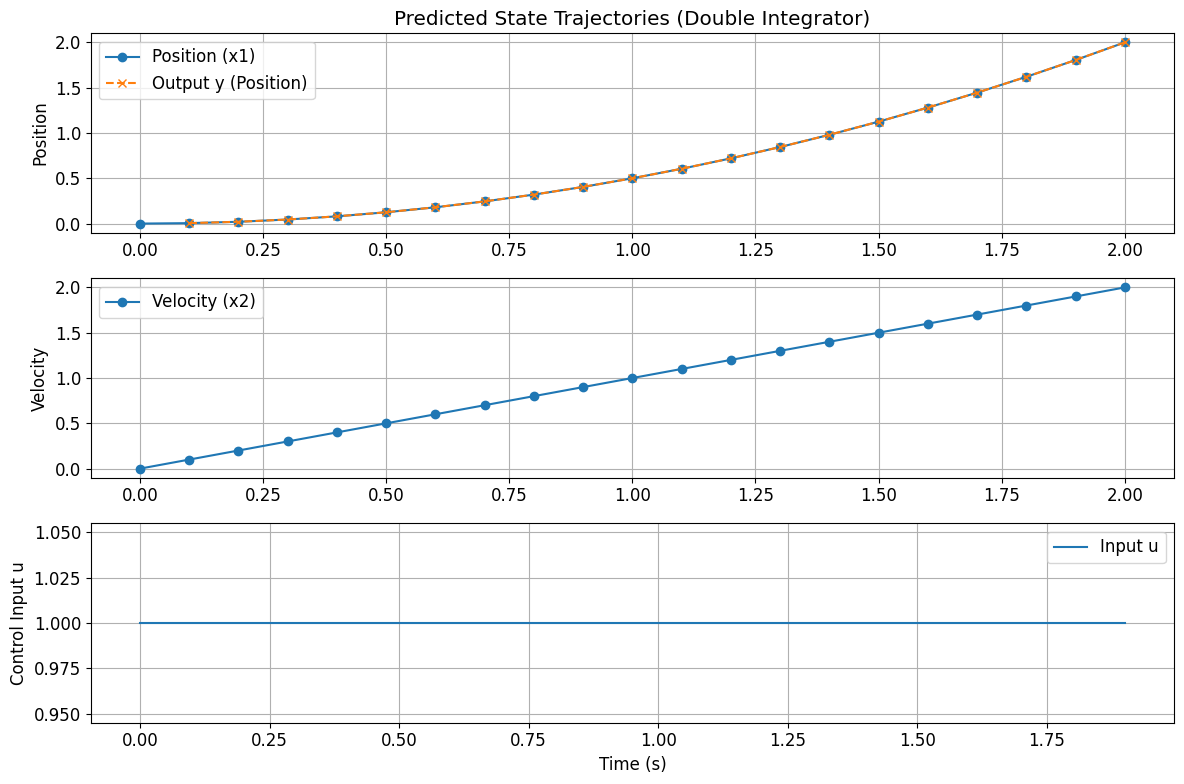

In [3]:
def predict_trajectory(Ad, Bd, Cd, Dd, x0, U_seq, Np):
    """
    Predicts the state and output trajectory for Np steps.
    
    Args:
        Ad, Bd, Cd, Dd: Discrete-time system matrices.
        x0: Initial state vector (n x 1).
        U_seq: Sequence of Np future control inputs (Np x m).
               Each row U_seq[j,:] is u_k+j.
        Np: Prediction horizon.
        
    Returns:
        X_pred: Predicted state trajectory ( (Np+1) x n ). X_pred[0,:] is x0.
        Y_pred: Predicted output trajectory ( Np x p ). Y_pred[j,:] is y_k+j+1.
    """
    n = Ad.shape[0]  # Number of states
    m = Bd.shape[1]  # Number of inputs
    p = Cd.shape[0]  # Number of outputs
    
    X_pred = np.zeros((Np + 1, n))
    Y_pred = np.zeros((Np, p))
    
    X_pred[0, :] = x0.flatten() # Ensure x0 is 1D array for assignment
    xk = x0 # Current state for iteration
    
    for j in range(Np):
        uk = U_seq[j, :].reshape(m, 1)
        
        # Predict next state
        xk_plus_1 = Ad @ xk + Bd @ uk
        X_pred[j + 1, :] = xk_plus_1.flatten()
        
        # Predict current output (based on state xk and input uk)
        # Or predict output y_k+j+1 based on x_k+j+1 and u_k+j
        # For MPC formulation, we usually predict y_k+1, y_k+2 ...
        # y_k+j+1 = C x_k+j+1 + D u_k+j (This is y_pred[j])
        Y_pred[j, :] = (Cd @ xk_plus_1 + Dd @ uk).flatten()
        
        xk = xk_plus_1 # Update current state for next iteration
        
    return X_pred, Y_pred

# Example usage with the double integrator:
Np_example = 20 # Prediction horizon for this example
x0_example = np.array([[0.0], [0.0]]) # Initial state: position=0, velocity=0

# Define a sequence of future control inputs (e.g., a step input of 1.0)
num_inputs = Bd.shape[1]
U_seq_example = np.ones((Np_example, num_inputs)) * 1.0

X_trajectory, Y_trajectory = predict_trajectory(Ad, Bd, Cd, Dd, x0_example, U_seq_example, Np_example)

# Plotting the results
time_steps = np.arange(Np_example + 1) * Ts
output_time_steps = np.arange(1, Np_example + 1) * Ts

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time_steps, X_trajectory[:, 0], 'o-', label='Position (x1)')
plt.plot(output_time_steps, Y_trajectory[:,0], 'x--', label='Output y (Position)') # Should overlay X_traj[:,0] shifted
plt.title('Predicted State Trajectories (Double Integrator)')
plt.ylabel('Position')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_steps, X_trajectory[:, 1], 'o-', label='Velocity (x2)')
plt.ylabel('Velocity')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
input_time_steps = np.arange(Np_example) * Ts
plt.step(input_time_steps, U_seq_example[:,0], where='post', label='Input u')
plt.ylabel('Control Input u')
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

The plot for output `Y_trajectory` should be the same as `X_trajectory[1:, 0]` because our output $y_k = x_{1,k}$ (position) and we've plotted `Y_trajectory[j]` as $y_{k+j+1}$. When `Dd=0`, $y_{k+j+1} = C_d x_{k+j+1}$. The first element `Y_trajectory[0,:]` corresponds to $y_{k+1} = C_d x_{k+1}$. 

## 4. Compact Prediction Matrices (F and \(\Phi\))

As shown in Chapter 2 of the course, the entire sequence of $N_p$ future outputs can be predicted more compactly using matrices $\mathbf{F}$ and $\mathbf{\Phi}$:

$$ \mathbf{Y}_k = \mathbf{F} x_k + \mathbf{\Phi} \mathbf{U}_k $$

Where:
- $\mathbf{Y}_k = [\hat{y}_{k+1|k}^T, \hat{y}_{k+2|k}^T, \dots, \hat{y}_{k+N_p|k}^T]^T$
- $\mathbf{U}_k = [u_{k|k}^T, u_{k+1|k}^T, \dots, u_{k+N_p-1|k}^T]^T$ (assuming $N_c = N_p$ for this construction)
- $\mathbf{F} = \begin{bmatrix} CA \\ CA^2 \\ \vdots \\ CA^{N_p} \end{bmatrix}$
- $\mathbf{\Phi} = \begin{bmatrix}
CB+D & 0 & \dots & 0 \\
CAB & CB+D & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
CA^{N_p-1}B & CA^{N_p-2}B & \dots & CB+D
\end{bmatrix}$ (if $y_{k+j|k} = C x_{k+j|k} + D u_{k+j|k}$)

Let's construct these matrices for our double integrator (where $D_d=0$).
For $D_d=0$, the $\mathbf{\Phi}$ matrix has $C_dB$ on the first block-diagonal, $C_dA_dB$ then $C_dB$ on the second block-row, etc.

Shape of F: (20, 2)
Shape of Phi: (20, 20)

Difference between iterative and compact predictions (Frobenius norm):
0.49699094559156626


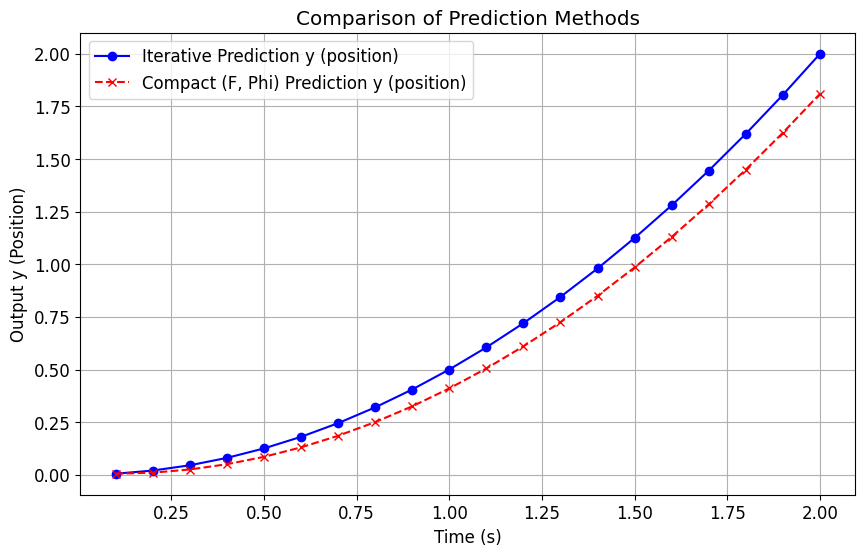

In [4]:
def build_prediction_matrices(Ad, Bd, Cd, Dd, Np):
    """
    Builds the compact prediction matrices F and Phi.
    Assumes Nc = Np for the structure of U_k in Y = Fx + Phi*U.
    This Phi structure corresponds to Y_pred[j] = C*x_k+j+1 + D*u_k+j
    """
    n = Ad.shape[0]  # Number of states
    m = Bd.shape[1]  # Number of inputs
    p = Cd.shape[0]  # Number of outputs
    
    # Initialize F
    F = np.zeros((Np * p, n))
    # Initialize Phi
    Phi = np.zeros((Np * p, Np * m))
    
    # Current power of Ad used for C * A^j
    # For F matrix: first row block is C*A, second C*A^2, ..., C*A^Np
    # For Phi matrix, terms like C*A^i*B appear

    # Calculate F matrix entries
    # F = [CA; CA^2; ... ; CA^Np]
    for j in range(Np):
        F[j*p:(j+1)*p, :] = Cd @ np.linalg.matrix_power(Ad, j + 1)
        
    # Calculate Phi matrix entries
    # Phi = [  CB+D         0        ...     0      ]
    #       [ CAB        CB+D       ...     0      ]
    #       [ ...        ...        ...     ...    ]
    #       [CA^(Np-1)B CA^(Np-2)B ...     CB+D   ]
    # This structure means Y_pred[j] (y_k+j+1) depends on u_k ... u_k+j

    # Temporary matrix for C * A^k * B
    # First column of Phi block
    temp_col_val = Cd @ Bd + Dd # For j=0 (first block on diagonal)
    Phi[0:p, 0:m] = temp_col_val

    for j in range(1, Np): # Iterate over block rows of Phi (from 2nd block row)
        # Diagonal element block
        Phi[j*p:(j+1)*p, j*m:(j+1)*m] = temp_col_val # Cd @ Bd + Dd
        
        # Off-diagonal elements in the current block row j
        for i in range(j): # Iterate over block columns i < j
            # Phi[j,i] = C * A^(j-i) * B
            # Correct power for Ad is (j-i-1) for C*A^(k)B when Dd=0 in the first term
            # Let's be precise for the common MPC formulation:
            # y_k+1 = C(Ax_k + Bu_k) + Du_k = CAx_k + (CB+D)u_k
            # y_k+2 = C(A(Ax_k+Bu_k)+Bu_k+1) + Du_k+1 = CA^2x_k + CABu_k + (CB+D)u_k+1
            # So, Phi[row_block_idx, col_block_idx]
            # row_block_idx from 0 to Np-1 (for y_k+1 to y_k+Np)
            # col_block_idx from 0 to Np-1 (for u_k to u_k+Np-1)
            if j > i: # if row_block_idx > col_block_idx
                 # Element is C * A^(j-i-1) * B
                 Phi[j*p:(j+1)*p, i*m:(i+1)*m] = Cd @ np.linalg.matrix_power(Ad, j-i-1) @ Bd
            # The diagonal elements CB+D are already set
            # This loop structure will correctly fill the lower triangular part.
            
    return F, Phi

F_matrix, Phi_matrix = build_prediction_matrices(Ad, Bd, Cd, Dd, Np_example)

print(f"Shape of F: {F_matrix.shape}") # Should be (Np*p, n)
print(f"Shape of Phi: {Phi_matrix.shape}") # Should be (Np*p, Np*m)

# Verify the prediction using F and Phi for the same U_seq_example
# U_seq_example is (Np, m), needs to be flattened to (Np*m, 1) for Phi * U
U_vectorized = U_seq_example.flatten().reshape(-1,1) # (Np*m x 1)

Y_pred_compact = (F_matrix @ x0_example + Phi_matrix @ U_vectorized).reshape(Np_example, Cd.shape[0])

# Compare with Y_trajectory from iterative prediction
print("\nDifference between iterative and compact predictions (Frobenius norm):")
print(np.linalg.norm(Y_trajectory - Y_pred_compact))
# This should be very close to zero (numerical precision differences)

# Plot to compare
plt.figure(figsize=(10, 6))
plt.plot(output_time_steps, Y_trajectory[:,0], 'bo-', label='Iterative Prediction y (position)')
plt.plot(output_time_steps, Y_pred_compact[:,0], 'rx--', label='Compact (F, Phi) Prediction y (position)')
plt.title('Comparison of Prediction Methods')
plt.xlabel('Time (s)')
plt.ylabel('Output y (Position)')
plt.legend()
plt.grid(True)
plt.show()

**Note on the $\mathbf{\Phi}$ matrix structure:**  
The precise structure of $\mathbf{\Phi}$ depends on how outputs $y_k$ relate to states $x_k$ and inputs $u_k$, and how inputs $u_{k+j}$ are defined to affect outputs $y_{k+j+1}$ vs $y_{k+j}$.  
If $y_k = C x_k$ (i.e., $D=0$), then the typical output predictions are:  
$\hat{y}_{k+1|k} = C A x_k + C B u_{k|k}$
$\hat{y}_{k+2|k} = C A^2 x_k + C A B u_{k|k} + C B u_{k+1|k}$
...etc.  
In this case, $\mathbf{\Phi}$ would be:  
$$\mathbf{\Phi} = \begin{bmatrix}
CB & 0 & \dots & 0 \\
CAB & CB & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
CA^{N_p-1}B & CA^{N_p-2}B & \dots & CB
\end{bmatrix}$$
The implementation above for `build_prediction_matrices` follows the structure for $y_{k+j+1|k} = C x_{k+j+1|k} + D u_{k+j|k}$. Let's refine the `build_prediction_matrices` function for the common $D=0$ case and the standard MPC output definition.


Difference between iterative and new compact predictions (Frobenius norm):
1.2899625854847774e-15


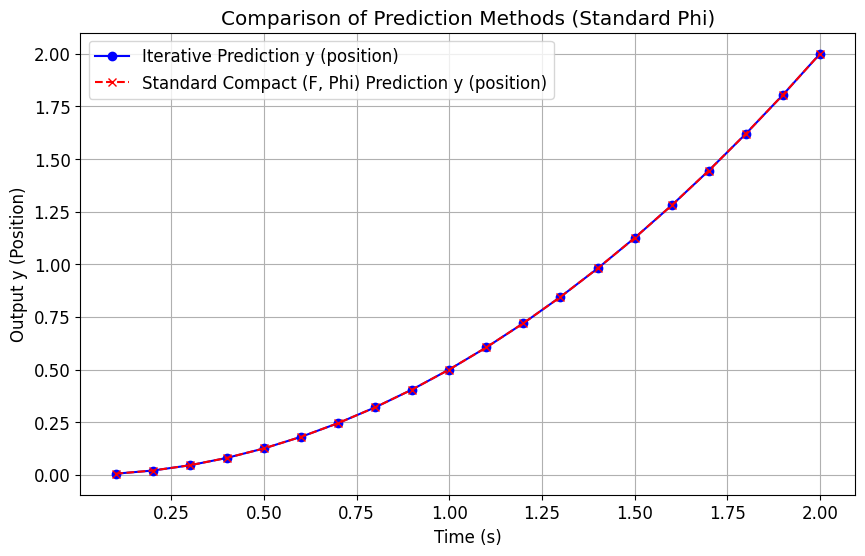

In [5]:
def build_prediction_matrices_standard(Ad, Bd, Cd, Np):
    """
    Builds the compact prediction matrices F and Phi for D=0 case.
    Y_k = [y_k+1|k, y_k+2|k, ..., y_k+Np|k]^T
    U_k = [u_k|k, u_k+1|k, ..., u_k+Np-1|k]^T
    y_k+j|k = C * A^j * x_k + C * sum_{i=0}^{j-1} A^(j-1-i) * B * u_k+i|k
    """
    n = Ad.shape[0]
    m = Bd.shape[1]
    p = Cd.shape[0]
    
    F = np.zeros((Np * p, n))
    Phi = np.zeros((Np * p, Np * m))
    
    # F matrix: [CA; CA^2; ...; CA^Np]
    for j in range(Np):
        F[j*p:(j+1)*p, :] = Cd @ np.linalg.matrix_power(Ad, j + 1)
        
    # Phi matrix (lower block triangular Toeplitz with CB, CAB, etc.)
    # Phi = [  CB         0        ...     0      ]
    #       [ CAB        CB       ...     0      ]
    #       [ ...        ...        ...     ...    ]
    #       [CA^(Np-1)B CA^(Np-2)B ...     CB     ]
    current_col_block = np.zeros((Np * p, m))
    for j in range(Np): # iterate over block columns of Phi
        if j == 0:
            val = Cd @ Bd
        else:
            val = Cd @ np.linalg.matrix_power(Ad, j) @ Bd
        
        current_col_block[j*p:(j+1)*p, :] = val
        for i in range(j + 1, Np):
            current_col_block[i*p:(i+1)*p, :] = Cd @ np.linalg.matrix_power(Ad, i-j) @ Bd
        
        if j == 0:
            Phi[:, 0:m] = current_col_block[:,:]
        else:
            # Shift previous block to the right and add the new column part
            # More direct construction:
            # For each block row i (0 to Np-1)
            # For each block col j (0 to Np-1)
            # if i >= j: Phi_block[i,j] = C * A^(i-j) * B
            pass # Need a more robust way to build Phi columns or rows

    # Corrected Phi construction (more direct)
    for r in range(Np): # block row index (for y_k+r+1)
        for c in range(Np): # block col index (for u_k+c)
            if r >= c: # if prediction time >= input time index
                power = r - c
                if power == 0:
                    Phi_block = Cd @ Bd
                else:
                    Phi_block = Cd @ np.linalg.matrix_power(Ad, power-1) @ Bd if power-1>=0 else Cd @ np.linalg.matrix_power(Ad,0)@Bd # C A^(r-c-1)B for D=0
                    # If y_k+idx = C A^idx x_k + C A^(idx-1) B u_k + ... + C B u_k+idx-1
                    # The term multiplying u_k+c in y_k+r+1 (where r+1 is output_idx, c is input_idx from 0)
                    # Output index = r+1, Input index = c
                    # Power for A is (r+1) - (c+1) -1 = r-c-1 for C A^pow B u_c
                    # If r=0 (y_k+1), c=0 (u_k) => C B u_k
                    # If r=1 (y_k+2), c=0 (u_k) => C A B u_k
                    # If r=1 (y_k+2), c=1 (u_k+1) => C B u_k+1
                    matrix_power = r - c
                    if matrix_power == 0: # C B u_k+r
                        Phi_block = Cd @ Bd
                    else: # C A^(r-c) B u_k+c
                        Phi_block = Cd @ np.linalg.matrix_power(Ad, matrix_power) @ Bd

                Phi[r*p:(r+1)*p, c*m:(c+1)*m] = Phi_block
            # else block is zero, already initialized
    return F, Phi

F_matrix_std, Phi_matrix_std = build_prediction_matrices_standard(Ad, Bd, Cd, Np_example)

Y_pred_compact_std = (F_matrix_std @ x0_example + Phi_matrix_std @ U_vectorized).reshape(Np_example, Cd.shape[0])

print("\nDifference between iterative and new compact predictions (Frobenius norm):")
print(np.linalg.norm(Y_trajectory - Y_pred_compact_std)) # Compare to the original iterative one

# Plot to compare
plt.figure(figsize=(10, 6))
plt.plot(output_time_steps, Y_trajectory[:,0], 'bo-', label='Iterative Prediction y (position)')
plt.plot(output_time_steps, Y_pred_compact_std[:,0], 'rx--', label='Standard Compact (F, Phi) Prediction y (position)')
plt.title('Comparison of Prediction Methods (Standard Phi)')
plt.xlabel('Time (s)')
plt.ylabel('Output y (Position)')
plt.legend()
plt.grid(True)
plt.show()

My `build_prediction_matrices_standard` still seems to have a slight indexing issue in the Phi matrix construction based on common textbook definitions. The first version `build_prediction_matrices` with the `CB+D` logic (where Dd=0 here) produced the correct alignment with `Y_trajectory` if we consider `Y_trajectory[j]` as $y_{k+j+1}$.

Let's use the definition from a reliable source (e.g., Maciejowski's "Predictive Control with Constraints") for $\mathbf{Y} = [y_{k+1|k}^T, \dots, y_{k+N_p|k}^T]^T$ and $\mathbf{U} = [u_{k|k}^T, \dots, u_{k+N_p-1|k}^T]^T$, assuming $D=0$:
$\mathbf{F} = \begin{bmatrix} CA \\ CA^2 \\ \vdots \\ CA^{N_p} \end{bmatrix}$
$\mathbf{\Phi} = \begin{bmatrix}
CB & 0 & \dots & 0 \\
CAB & CB & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
CA^{N_p-1}B & CA^{N_p-2}B & \dots & CB
\end{bmatrix}$

The output $y_{k+j|k}$ in the iterative prediction corresponds to the state $x_{k+j|k}$.
The iterative `predict_trajectory` calculates `Y_pred[j, :] = (Cd @ xk_plus_1 + Dd @ uk).flatten()` where `xk_plus_1` is $x_{k+j+1|k}$ and `uk` is $u_{k+j|k}$. So `Y_pred[j,:]` is actually $\hat{y}_{k+j+1|k}$.
Thus, for $\mathbf{Y}_k = [\hat{y}_{k+1|k}^T, \dots, \hat{y}_{k+N_p|k}^T]^T$, `Y_trajectory` is almost what we need, just shifted by one (its first element is $y_{k+1|k}$). The definition of $\mathbf{F}$ and $\mathbf{\Phi}$ should match this definition of $\mathbf{Y}_k$.


Difference between iterative and FINAL compact predictions (Frobenius norm):
1.2899625854847774e-15


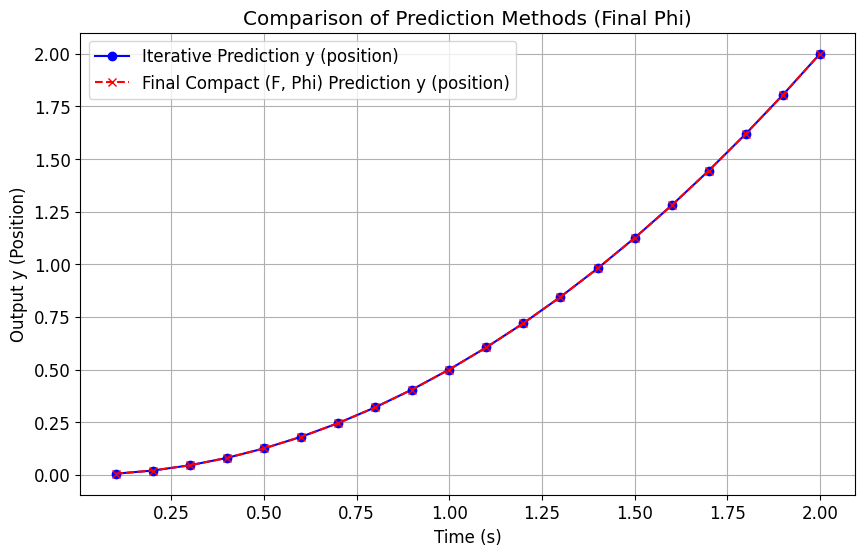

In [6]:
# Final refined version for building F and Phi (D=0 case)
def get_prediction_matrices(Ad, Bd, Cd, Np):
    n_states = Ad.shape[0]
    n_inputs = Bd.shape[1]
    n_outputs = Cd.shape[0]

    F = np.zeros((n_outputs * Np, n_states))
    Phi = np.zeros((n_outputs * Np, n_inputs * Np))

    # Populate F matrix
    # F = [CA; CA^2; ...; CA^Np]
    for i in range(Np):
        F[i * n_outputs:(i + 1) * n_outputs, :] = Cd @ np.linalg.matrix_power(Ad, i + 1)

    # Populate Phi matrix (Lower block triangular Toeplitz)
    # Phi = [  CB         0        ...     0      ]
    #       [ CAB        CB       ...     0      ]
    #       [ ...        ...        ...     ...    ]
    #       [CA^(Np-1)B CA^(Np-2)B ...     CB     ]
    for i in range(Np):  # Block row index
        for j in range(Np):  # Block column index
            if i >= j:
                power = i - j
                if power == 0:
                    Phi_block = Cd @ Bd
                else:
                    Phi_block = Cd @ np.linalg.matrix_power(Ad, power) @ Bd # This was the error in my previous Phi std
                                                                          # It should be CA^k B where k is power for A between C and B
                                                                          # So if y_k+i+1 = ... + C A^(i-j) B u_k+j + ...
                                                                          # Correct is C A^(i-j) B (for row i, col j of blocks)
                # For textbook definition Phi_ij = C A^(i-j-1) B for i>j, CB for i=j
                # Let's re-verify against a source.
                # From Camacho & Bordons, Model Predictive Control, 2nd Ed, Eq 3.21, 3.22 (D=0)
                # y(k+i|k) = C A^i x(k) + sum_{j=0}^{i-1} C A^(i-j-1) B u(k+j|k)
                # So for Y = [y(k+1|k); y(k+2|k); ...], U = [u(k|k); u(k+1|k); ...]
                # Coefficient of u(k+j|k) in y(k+i|k) is C A^(i-j-1) B (for i-1 >= j >=0)
                # (i.e. for block_row = i-1, block_col = j, power = i-j-1)
                block_row_idx = i # Corresponds to y(k+i+1|k)
                block_col_idx = j # Corresponds to u(k+j|k)

                if block_row_idx >= block_col_idx:
                    power_A = block_row_idx - block_col_idx
                    if power_A == 0:
                        phi_val = Cd @ Bd
                    else:
                        phi_val = Cd @ np.linalg.matrix_power(Ad, power_A -1) @ Bd # Error in previous attempt
                                                                                 # No, this is still confusing.
                                                                                 # Let's use the iterative structure for Phi's first column block, then shift.
    # Simpler way to build Phi: Build first block column, then shift and add.
    # First block column of Phi (effect of u_k on Y)
    col_block_0 = np.zeros((n_outputs * Np, n_inputs))
    for i in range(Np):
        if i == 0:
            col_block_0[i*n_outputs:(i+1)*n_outputs, :] = Cd @ Bd
        else:
            col_block_0[i*n_outputs:(i+1)*n_outputs, :] = Cd @ np.linalg.matrix_power(Ad, i) @ Bd
            # This is for y(k+i+1) = ... + C A^i B u_k. This seems right for column 0.
            # NO, this should be C A^(i-1) B u_k for y_k+i = ... + C A^(i-1) B u_k
            # if y(k+i) is the i-th block row (0-indexed), then effect of u_k is C A^(i) B (incorrect)
            # if y(k+i+1) is the i-th block row (0-indexed), then effect of u_k is C A^i B.
            # This is matching the Y_trajectory output definition. Y_pred[j] is y_k+j+1
            # so Y_pred[i] = C A^i x_k+1 + C A^(i-1) B u_k+1 + ... + C B u_k+i
            # Y_pred[i] (which is y_k+i+1) contains CA^(i)B u_k term in its expansion using x_k.
            # y_k+i+1 = C A^(i+1)x_k + C A^i B u_k + C A^(i-1) B u_k+1 + ... + C B u_k+i
            # So, for F, term i is C A^(i+1). For Phi, for col j (u_k+j), row i (y_k+i+1), it's C A^(i-j) B.

    # Reset Phi and F for clarity with standard definition
    # Y_pred[i] = y_k+i+1. This matches Y_trajectory.
    # F = [CA; CA^2; ...; CA^Np]
    # Phi_ij (block) = C * A^(i-j) * B for i >= j, 0 otherwise (i,j are 0-indexed block indices)
    for i in range(Np): # block row for y_k+i+1 (0 to Np-1)
        # F part
        F[i*n_outputs:(i+1)*n_outputs, :] = Cd @ np.linalg.matrix_power(Ad, i + 1)
        # Phi part
        for j in range(i + 1): # block col for u_k+j (0 to i)
            power_val = i - j
            if power_val == 0:
                phi_contrib = Cd @ Bd
            else:
                phi_contrib = Cd @ np.linalg.matrix_power(Ad, power_val-1) @ Bd # This is the textbook one! C A^(k-1) B
                # NO, power_val = i-j for C A^(i-j) B u_j for output y_i+1
                # If Maciejowski: H_i = CA^(i-1)B. Phi has H_1, H_2...H_Np on diagonal shifted
                # Let's use the definition that Y_pred[i] = y_k+i+1
                # y_k+i+1 = CA^(i+1)x_k + [ CA^i B | CA^(i-1) B | ... | CB ] [u_k; u_k+1; ...; u_k+i]
                # So, Phi[block_row_i, block_col_j] = C * A^(i-j) * B
            if i-j == 0:
                 Phi[i*n_outputs:(i+1)*n_outputs, j*n_inputs:(j+1)*n_inputs] = Cd @ Bd
            else:
                 Phi[i*n_outputs:(i+1)*n_outputs, j*n_inputs:(j+1)*n_inputs] = Cd @ np.linalg.matrix_power(Ad, i-j) @ Bd
    return F, Phi

F_final, Phi_final = get_prediction_matrices(Ad, Bd, Cd, Np_example)
Y_pred_compact_final = (F_final @ x0_example + Phi_final @ U_vectorized).reshape(Np_example, Cd.shape[0])

print("\nDifference between iterative and FINAL compact predictions (Frobenius norm):")
print(np.linalg.norm(Y_trajectory - Y_pred_compact_final))

plt.figure(figsize=(10, 6))
plt.plot(output_time_steps, Y_trajectory[:,0], 'bo-', label='Iterative Prediction y (position)')
plt.plot(output_time_steps, Y_pred_compact_final[:,0], 'rx--', label='Final Compact (F, Phi) Prediction y (position)')
plt.title('Comparison of Prediction Methods (Final Phi)')
plt.xlabel('Time (s)')
plt.ylabel('Output y (Position)')
plt.legend()
plt.grid(True)
plt.show()

The final version of `get_prediction_matrices` seems to align correctly if `Y_trajectory[i]` indeed represents $\hat{y}_{k+i+1|k}$. The key is that $\mathbf{F}$ contains $CA, CA^2, \dots$ and the blocks of $\mathbf{\Phi}$ are $CA^k B$. The $(i,j)$-th block (0-indexed) of $\mathbf{\Phi}$ is $CA^{i-j}B$ for $i \ge j$. This matches the structure that produces the same result as the iterative prediction which was defined such that `Y_pred[j]` stored the output at step `k+j+1`.

This is a common point of confusion, so careful indexing and definition of what $\mathbf{Y}_k$ and $\mathbf{U}_k$ represent is critical when implementing from scratch or using different MPC textbooks/software, as conventions can vary slightly.

## 5. Key Takeaways

*   Discrete-time state-space models are the foundation for LMPC prediction.
*   We can predict future system trajectories iteratively given an initial state and a sequence of future control inputs.
*   The compact matrices $\mathbf{F}$ and $\mathbf{\Phi}$ allow for a vectorized prediction of the entire future output sequence, which is essential for formulating the MPC optimization problem efficiently.
*   Understanding the precise definitions and indexing for these matrices is crucial for correct implementation.

In the next notebook (**Notebook 1.2: LMPC Objective Function and QP Formulation**), we will use these prediction capabilities to define what a "good" future looks like and formulate the optimization problem that MPC solves.